In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [98]:
def load():
    df = pd.read_csv("datasets/titanic.csv")
    return df

In [99]:
pd.set_option("display.max_columns", None)

In [100]:
df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [101]:
#1. feature engineering
df.columns = [col.upper() for col in df.columns] #tüm col'lar büyük harf

In [102]:
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype('int') #cabin sütunundaki değerlerin boş olup olmadığını gösteren yeni değişken

df["NEW_NAME_COUNT"] = df["NAME"].str.len() 
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))

df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr.")])) #doktor olan yolcular

df['NEW_TITLE'] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False) #ünvan çıkarımı mr, mrs vs

df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1 #ailedeki kişi sayısı

df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"] #yaş ve zenginlik çarpımı gibi

df.loc[((df['SIBSP'] + df['PARCH']) > 0), "NEW_IS_ALONE"] = "NO" 
df.loc[((df['SIBSP'] + df['PARCH']) == 0), "NEW_IS_ALONE"] = "YES" #yolcu yalnız mı değil mi?

#yaşa göre segmentasyon
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior' 

# cinsiyet ve yaşa göre segmentasyon
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,23,4,0,Mr,2,66.0,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,51,7,0,Mrs,2,38.0,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,22,3,0,Miss,1,78.0,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,44,7,0,Mrs,2,35.0,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,24,4,0,Mr,1,105.0,YES,mature,maturemale


In [103]:
#değişken türlerini ayırma

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    
    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [104]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8


In [105]:
print(cat_cols, num_cols, cat_but_car, sep="\n")

['SEX', 'EMBARKED', 'NEW_TITLE', 'NEW_IS_ALONE', 'NEW_AGE_CAT', 'NEW_SEX_CAT', 'SURVIVED', 'PCLASS', 'SIBSP', 'PARCH', 'NEW_CABIN_BOOL', 'NEW_NAME_WORD_COUNT', 'NEW_NAME_DR', 'NEW_FAMILY_SIZE']
['PASSENGERID', 'AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']
['NAME', 'TICKET', 'CABIN']


In [106]:
#yakalanmayan kardinal değeri num_cols'tan çıkarma
num_cols = [col for col in num_cols if col not in "PASSENGERID"]
#veya/ num_cols = [col for col in num_cols if col != "PASSENGERID"] 

In [107]:
#2. outliers:outlier threshold'larını belirleme
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [108]:
#sütunda outlier olup olmadığını kontrol etme
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [109]:
#aykırı değerler var mı yok mu kontrol
for col in num_cols:
    print(col, check_outlier(df, col))

AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True


In [110]:
#aykırı değerleri eşik değerlerle değiştirme
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [111]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [112]:
for col in num_cols:
    print(col, check_outlier(df, col))

AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


In [113]:
#3.eksik değerler

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [114]:
missing_values_table(df)
#3 değişkenin eksik olması AGE değişkeninin olmamasından dolayı.

                n_miss  ratio
CABIN              687  77.10
AGE                177  19.87
NEW_AGE_PCLASS     177  19.87
NEW_AGE_CAT        177  19.87
NEW_SEX_CAT        177  19.87
EMBARKED             2   0.22


In [115]:
#cabin çok eksik. o yüzden atılmalı. ticket ve name de işlevsiz
df.drop(["CABIN", "TICKET", "NAME"], axis=1, inplace=True)

In [116]:
#yaş değişkeninin eksik değerlerini aynı title'a sahip yolcuların yaş medyanları ile doldurma
df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))

In [117]:
#yaş atandıktan sonra yaşa bağlı değişkenlerin tekrarlanması

df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"] #yaş ve zenginlik çarpımı gibi

df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior' 

# cinsiyet ve yaşa göre segmentasyon
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

In [118]:
missing_values_table(df)

          n_miss  ratio
EMBARKED       2   0.22


In [119]:
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)

In [120]:
#4.label encoding

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] 
               and df[col].nunique() == 2] #int veya float olmadığı halde iki kategorisi olan (cinsiyet ve yalnız olup olmama gibi) özellikleri seçme

binary_cols

['SURVIVED', 'SEX', 'NEW_NAME_DR', 'NEW_IS_ALONE']

In [121]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler

In [122]:
#label encoder fonksiyonu
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [123]:
for col in binary_cols:
    df = label_encoder(df, col)

In [124]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,1,22.0,1,0,7.2500,S,0,23,4,0,Mr,2,66.0,0,mature,maturemale
1,2,1,1,0,38.0,1,0,65.6344,C,1,45,7,0,Mrs,2,38.0,0,mature,maturefemale
2,3,1,3,0,26.0,0,0,7.9250,S,0,22,3,0,Miss,1,78.0,1,mature,maturefemale
3,4,1,1,0,35.0,1,0,53.1000,S,1,44,7,0,Mrs,2,35.0,0,mature,maturefemale
4,5,0,3,1,35.0,0,0,8.0500,S,0,24,4,0,Mr,1,105.0,1,mature,maturemale


In [125]:
#rare encoder
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [126]:
rare_analyser(df, "SURVIVED", cat_cols)

SEX : 2
   COUNT     RATIO  TARGET_MEAN
0    314  0.352413     0.742038
1    577  0.647587     0.188908


EMBARKED : 3
   COUNT     RATIO  TARGET_MEAN
C    168  0.188552     0.553571
Q     77  0.086420     0.389610
S    646  0.725028     0.339009


NEW_TITLE : 17
          COUNT     RATIO  TARGET_MEAN
Capt          1  0.001122     0.000000
Col           2  0.002245     0.500000
Countess      1  0.001122     1.000000
Don           1  0.001122     0.000000
Dr            7  0.007856     0.428571
Jonkheer      1  0.001122     0.000000
Lady          1  0.001122     1.000000
Major         2  0.002245     0.500000
Master       40  0.044893     0.575000
Miss        182  0.204265     0.697802
Mlle          2  0.002245     1.000000
Mme           1  0.001122     1.000000
Mr          517  0.580247     0.156673
Mrs         125  0.140292     0.792000
Ms            1  0.001122     1.000000
Rev           6  0.006734     0.000000
Sir           1  0.001122     1.000000


NEW_IS_ALONE : 2
   COUNT     RA

In [127]:
#encoder fonksiyonu
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [128]:
df = rare_encoder(df, 0.01)

In [129]:
#one hot encoding
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [130]:
#ohe fonksiyonu
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [131]:
df = one_hot_encoder(df, ohe_cols)

In [132]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,22.0,7.2500,0,23,0,66.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2,1,0,38.0,65.6344,1,45,0,38.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,0,26.0,7.9250,0,22,0,78.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,35.0,53.1000,1,44,0,35.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,1,35.0,8.0500,0,24,0,105.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [133]:
#yeniden rare_analyser kullanacağız: yeni değişkenlerin gerekli olup olmadığını görmek için
cat_cols, num_cols, cat_but_car = grab_col_names(df)
print(cat_cols, num_cols, cat_but_car, sep="\n")

Observations: 891
Variables: 52
cat_cols: 47
num_cols: 5
cat_but_car: 0
num_but_cat: 47
['SURVIVED', 'SEX', 'NEW_CABIN_BOOL', 'NEW_NAME_DR', 'NEW_IS_ALONE', 'PCLASS_2', 'PCLASS_3', 'SIBSP_1', 'SIBSP_2', 'SIBSP_3', 'SIBSP_4', 'SIBSP_5', 'SIBSP_8', 'PARCH_1', 'PARCH_2', 'PARCH_3', 'PARCH_4', 'PARCH_5', 'PARCH_6', 'EMBARKED_Q', 'EMBARKED_S', 'NEW_NAME_WORD_COUNT_4', 'NEW_NAME_WORD_COUNT_5', 'NEW_NAME_WORD_COUNT_6', 'NEW_NAME_WORD_COUNT_7', 'NEW_NAME_WORD_COUNT_8', 'NEW_NAME_WORD_COUNT_9', 'NEW_NAME_WORD_COUNT_14', 'NEW_TITLE_Miss', 'NEW_TITLE_Mr', 'NEW_TITLE_Mrs', 'NEW_TITLE_Rare', 'NEW_FAMILY_SIZE_2', 'NEW_FAMILY_SIZE_3', 'NEW_FAMILY_SIZE_4', 'NEW_FAMILY_SIZE_5', 'NEW_FAMILY_SIZE_6', 'NEW_FAMILY_SIZE_7', 'NEW_FAMILY_SIZE_8', 'NEW_FAMILY_SIZE_11', 'NEW_AGE_CAT_senior', 'NEW_AGE_CAT_young', 'NEW_SEX_CAT_maturemale', 'NEW_SEX_CAT_seniorfemale', 'NEW_SEX_CAT_seniormale', 'NEW_SEX_CAT_youngfemale', 'NEW_SEX_CAT_youngmale']
['PASSENGERID', 'AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']
[]


In [134]:
num_cols = [col for col in num_cols if col not in "PASSENGERID"]

In [135]:
rare_analyser(df, "SURVIVED", cat_cols)

SURVIVED : 2
   COUNT     RATIO  TARGET_MEAN
0    549  0.616162          0.0
1    342  0.383838          1.0


SEX : 2
   COUNT     RATIO  TARGET_MEAN
0    314  0.352413     0.742038
1    577  0.647587     0.188908


NEW_CABIN_BOOL : 2
   COUNT     RATIO  TARGET_MEAN
0    687  0.771044     0.299854
1    204  0.228956     0.666667


NEW_NAME_DR : 2
   COUNT     RATIO  TARGET_MEAN
0    884  0.992144     0.383484
1      7  0.007856     0.428571


NEW_IS_ALONE : 2
   COUNT     RATIO  TARGET_MEAN
0    354  0.397306     0.505650
1    537  0.602694     0.303538


PCLASS_2 : 2
   COUNT    RATIO  TARGET_MEAN
0    707  0.79349     0.360679
1    184  0.20651     0.472826


PCLASS_3 : 2
   COUNT     RATIO  TARGET_MEAN
0    400  0.448934     0.557500
1    491  0.551066     0.242363


SIBSP_1 : 2
   COUNT     RATIO  TARGET_MEAN
0    682  0.765432     0.337243
1    209  0.234568     0.535885


SIBSP_2 : 2
   COUNT     RATIO  TARGET_MEAN
0    863  0.968575     0.381228
1     28  0.031425     0.464286


In [136]:
#kullanışsız sütunları belirleme

useless_cols = [col for col in df.columns if df[col].nunique() == 2 and 
                (df[col].value_counts()/len(df) < 0.01).any(axis=None)]

useless_cols

['NEW_NAME_DR',
 'SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

In [137]:
df.drop(useless_cols,axis=1, inplace=True)

In [138]:
#bu problemde işlevsiz ama ihtiyaç durumunda standard scaler
ss = StandardScaler()

In [139]:
df[num_cols] = ss.fit_transform(df[num_cols])

df[num_cols].head()

,AGE,FARE,NEW_NAME_COUNT,NEW_AGE_PCLASS
0,-0.560638,-0.820552,-0.436675,0.066488
1,0.663302,2.031623,2.248303,-0.790429
2,-0.254653,-0.787578,-0.558720,0.433739
3,0.433813,1.419297,2.126258,-0.882241
4,0.433813,-0.781471,-0.314631,1.260052


In [140]:
#Model

y = df["SURVIVED"]
X = df.drop(["SURVIVED", "PASSENGERID"], axis=1)

In [141]:
#train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

In [142]:
#model kurulumu
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.8134328358208955

In [49]:
#preprocessing olmasaydı sonuç ne olurdu?

dff = load()
dff.dropna(inplace=True)
dff = pd.get_dummies(dff, columns=["Sex", "Embarked"], drop_first=True)
y = dff["Survived"]
X = dff.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [50]:
rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7272727272727273

In [143]:
#feature importance
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

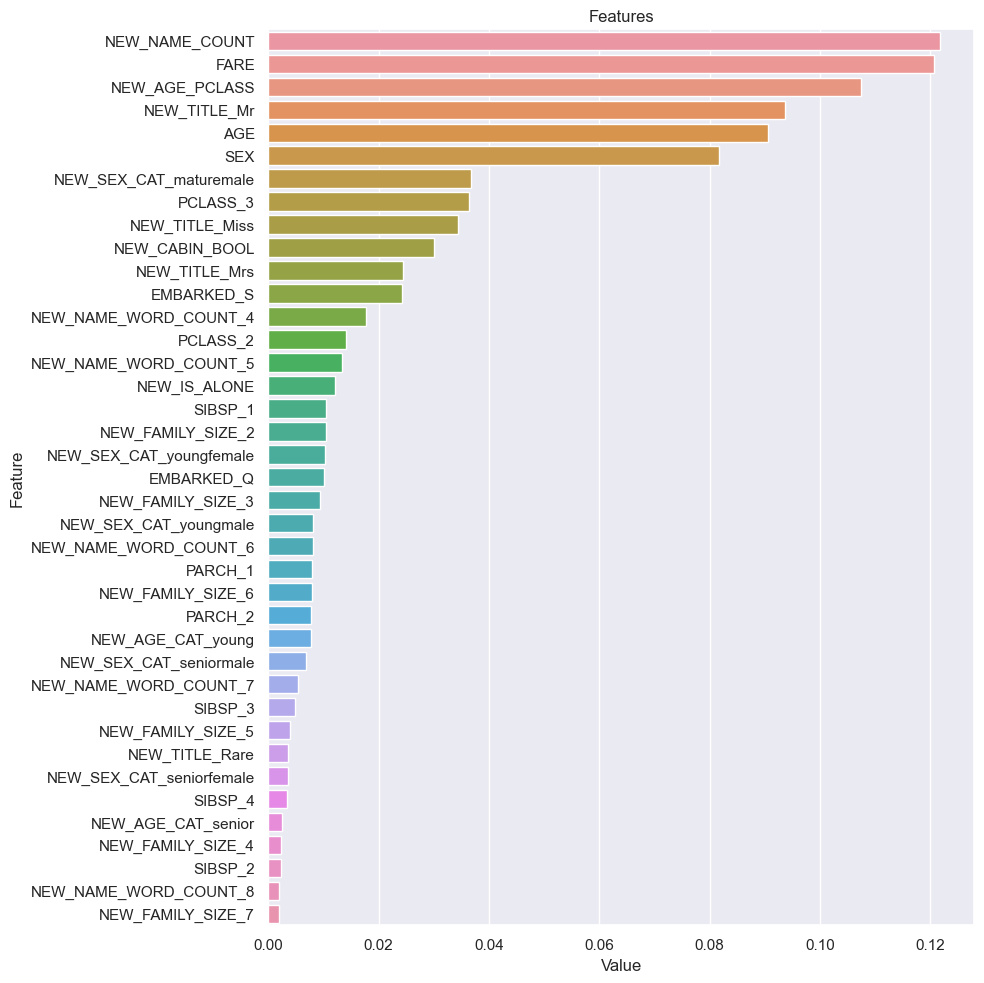

In [146]:
plot_importance(rf_model, X_train)